# Variational Autoencoder for STL Objects

The goal of this notebook is to produce a Variational Autoencoder (VAE) that can encode and then decode Voxel objects.

This VAE is based off of the implementation demonstrated in [this YouTube video](https://www.youtube.com/watch?v=LtpU1yBStlU) [github link](https://github.com/ajbrock/Generative-and-Discriminative-Voxel-Modeling/blob/master/Generative/VAE.py). We refer to this VAE as the "Example VAE" in this notebook.

## Notes

* We still use Thingi10k as our data source. Thingi10k's objects are stl files, so we employ methods explored in stl_voxelization.ipynb to convert each stl file to binvox (a voxel format).
* The Example VAE is written in python with theano and lasagne
* Lasagne's Glorot Uniform initializer \[[docs](https://lasagne.readthedocs.io/en/latest/modules/init.html)\] is the same as Xavier Uniform initializer (Tensorflow's API [docs](https://www.tensorflow.org/api_docs/python/tf/glorot_uniform_initializer)).
* The encoder uses conv3d layers and the decoder uses conv3d_transpose layers; TF describes [here] (https://www.tensorflow.org/api_docs/python/tf/nn/conv3d_transpose) that conv3d_transpose is the opposite of conv3d.

## Env Setup

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import os

import matplotlib.pyplot as plt
%matplotlib inline

# autoreload modules
%load_ext autoreload
%autoreload 2

# set seeds for reproducibility
np.random.seed(12)
tf.set_random_seed(12)

## Data Import

In [46]:
# import data
import env
from data.thingi10k import Thingi10k
from data.stl import save_vectors_as_stl, plot_mesh
from data.voxels import plot_voxels
from models import MODEL_DIR


#thingi = Thingi10k.init10k(pctile=.8)
# apply filter
#thingi.filter_by_tag('animal')
thingi = Thingi10k.init10()
n_samples = len(thingi)
n_samples

10

In [64]:
class VariationalAutoencoder():
    
    def __init__(self, input_dim, latent_dim, learning_rate, keep_prob, verbose=False, 
                 kl_div_loss_weight=5, recon_loss_weight=5e-4, ckpt_dir='voxel_vae'):
        """
        Args:
            kl_div_loss_weight: float, weight for KL Divergence loss when computing total loss
            recon_loss_weight: float, weight for reconstruction loss when computing total loss

        """
        # network and training params
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        self.keep_prob = keep_prob
        self.verbose = verbose
        self.kl_div_loss_weight = kl_div_loss_weight
        self.recon_loss_weight = recon_loss_weight
        
        self._input_x = tf.placeholder(tf.float32, shape=(None, self.input_dim, self.input_dim, self.input_dim, 1))
        self._keep_prob = tf.placeholder(dtype=tf.float32)
        self._trainable = tf.placeholder(dtype=tf.bool)

        self.sculptor, self.loss, self.optimizer = self._init_graph(self._input_x, self._keep_prob, self._trainable)
        
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()
        
        # Setup Model Saving
        self.ckpt_dir = os.path.join(MODEL_DIR, ckpt_dir)
        self.saver = tf.train.Saver()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
        
    def _print_shape(self, tensor, name=None):
        if self.verbose:
            if not name:
                name = tensor.name
            print('{}:'.format(name), tensor.shape)
        return
    
    def _make_encoder(self, input_x, keep_prob, trainable):
        
        # tf conv3d: https://www.tensorflow.org/api_docs/python/tf/layers/conv3d
        # tf glorot init: https://www.tensorflow.org/api_docs/python/tf/glorot_uniform_initializer
        conv1 = tf.layers.conv3d(input_x,
                                 filters=8,
                                 kernel_size=[3, 3, 3],
                                 strides=(1, 1, 1),
                                 padding='valid',
                                 #activation=tf.nn.elu,
                                 kernel_initializer=tf.initializers.glorot_uniform(),
                                 name='enc_conv1')
        self._print_shape(conv1)
        # the Example VAE specifies the activation functions as part of the layer
        # we specify the activation function as a seperate tensor
        # it is unknown if this is the preferred method in Tensorflow, but we know
        # it works from work in the 3D-VAE-GAN notebook
        # we also take advantage of batch_normalization
        # more info here:
        # https://medium.com/@ilango100/batch-normalization-speed-up-neural-network-training-245e39a62f85
        # with the hope that it gives speed without sacrificing quality
        # tf batch norm: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization
        # tf elu (exponential linear unit): https://www.tensorflow.org/api_docs/python/tf/nn/elu
        lrelu1 = tf.nn.elu(tf.layers.batch_normalization(conv1, training=trainable), name='enc_lrelu1')
        self._print_shape(lrelu1)

        conv2 = tf.layers.conv3d(lrelu1,
                                 filters=16,
                                 kernel_size=[3, 3, 3],
                                 strides=(2, 2, 2),
                                 padding='same',
                                 kernel_initializer=tf.initializers.glorot_uniform(),
                                 name='enc_conv2')
        self._print_shape(conv2)
        lrelu2 = tf.nn.elu(tf.layers.batch_normalization(conv2, training=trainable), name='enc_lrelu2')
        self._print_shape(lrelu2)

        conv3 = tf.layers.conv3d(lrelu2,
                                 filters=32,
                                 kernel_size=[3, 3, 3],
                                 strides=(1, 1, 1),
                                 padding='valid',
                                 kernel_initializer=tf.initializers.glorot_uniform(),
                                 name='enc_conv3')
        self._print_shape(conv3)
        lrelu3 = tf.nn.elu(tf.layers.batch_normalization(conv3, training=trainable), name='enc_lrelu3')
        self._print_shape(lrelu3)
        
        conv4 = tf.layers.conv3d(lrelu2,
                                 filters=64,
                                 kernel_size=[3, 3, 3],
                                 strides=(2, 2, 2),
                                 padding='same',
                                 kernel_initializer=tf.initializers.glorot_uniform(),
                                 name='enc_conv4')
        self._print_shape(conv4)
        lrelu4 = tf.nn.elu(tf.layers.batch_normalization(conv4, training=trainable), name='enc_lrelu4')
        self._print_shape(lrelu4)
        
        # Apply one fully-connected layer after Conv3d layers
        # tf dense layer: https://www.tensorflow.org/api_docs/python/tf/layers/dense
        dense1 = tf.layers.dense(lrelu4,
                                 units=343,
                                 kernel_initializer=tf.initializers.glorot_uniform(),
                                 name='enc_dense1')
        self._print_shape(dense1)
        network_output = tf.nn.elu(tf.layers.batch_normalization(dense1, training=trainable), name='enc_lrelu5')
        self._print_shape(network_output)
        
        # apply dropout to prevent overtraining
        # why do we flatten?
        enc_output = tf.layers.flatten(tf.nn.dropout(network_output, keep_prob), name='enc_output')
        self._print_shape(enc_output)
        
        # transform the network output into the latent vector
        z_mu = tf.layers.dense(enc_output,
                         units=self.latent_dim,
                         # Example VAE does not use an initializer here
                         #kernel_initializer=tf.initializers.glorot_uniform(),
                         name='enc_mu')
        self._print_shape(z_mu)

        # Example VAE uses a custom layer to extract sigma
        # Here we borrow sigma calc from 3D-VAE-GAN
        z_sig = 0.5 * tf.layers.dense(enc_output, units=self.latent_dim, name='enc_sig')
        self._print_shape(z_sig, 'enc_sig')
        
        # epsilon is a random draw from the latent space
        epsilon = tf.random_normal(tf.stack([tf.shape(enc_output)[0], self.latent_dim]))
        self._print_shape(epsilon, 'epsilon')
        z = z_mu + tf.multiply(epsilon, tf.exp(z_sig))
        self._print_shape(z, 'z')
        
        return z, z_mu, z_sig
    
    def _make_decoder(self, input_z, trainable):
        
        # There is some magic in the Example VAE that adds conditional input based on the
        # class of the image. We do not have that luxury as we are attempting to do this
        # with input that lacks classes.
        # TODO: if poor results, try classes
        self._print_shape(input_z, 'input_z')

        # Why conv3d_transpose instead of conv3d?
        #
        # from https://www.tensorflow.org/api_docs/python/tf/nn/conv3d_transpose,
        #     "This operation is sometimes called "deconvolution" after Deconvolutional Networks,
        #      but is actually the transpose (gradient) of conv3d rather than an actual deconvolution."
        #
        # conv3d_transpose: https://www.tensorflow.org/api_docs/python/tf/layers/conv3d_transpose
        dense1 = tf.layers.dense(input_z,
                                 units=343,
                                 kernel_initializer=tf.initializers.glorot_uniform(),
                                 name='dec_dense1')
        self._print_shape(dense1)
        lrelu1 = tf.nn.elu(tf.layers.batch_normalization(dense1, training=trainable))
        self._print_shape(lrelu1)

        #z = tf.reshape(z, (-1, 1, 1, 1, n_latent))
        reshape_z = tf.reshape(lrelu1, shape=(-1, 7, 7, 7, 1), name='reshape_z')
        self._print_shape(reshape_z)
        #print('reshape_z: ', reshape_z.shape)
        #for value in reshape_z.shape:
        #    print(type(value))

        conv1 = tf.layers.conv3d_transpose(reshape_z,
                                           filters=64,
                                           kernel_size=[3, 3, 3],
                                           strides=(1, 1, 1),
                                           padding='same',
                                           # Example VAE does not mention bias
                                           #use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv1')
        self._print_shape(conv1)
        lrelu2 = tf.nn.elu(tf.layers.batch_normalization(conv1, training=trainable), name='dec_lrelu2')
        self._print_shape(lrelu2)

        conv2 = tf.layers.conv3d_transpose(lrelu2,
                                           filters=32,
                                           kernel_size=[3, 3, 3],
                                           # Example VAE used .5 stride values, but Tensorflow complains
                                           # of being forced to use a float value here
                                           #strides=(1.0 / 2, 1.0 / 2, 1.0 / 2),
                                           strides=(2, 2, 2),
                                           padding='same',
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv2')
        self._print_shape(conv2)
        lrelu3 = tf.nn.elu(tf.layers.batch_normalization(conv2, training=trainable), name='dec_lrelu3')
        self._print_shape(lrelu3)

        conv3 = tf.layers.conv3d_transpose(lrelu3,
                                           filters=16,
                                           kernel_size=[3, 3, 3],
                                           strides=(1, 1, 1),
                                           # changed to valid to hit correct dimension
                                           padding='valid',
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv3')
        self._print_shape(conv3)
        lrelu4 = tf.nn.elu(tf.layers.batch_normalization(conv3, training=trainable), name='dec_lrelu4')
        self._print_shape(lrelu4)

        conv4 = tf.layers.conv3d_transpose(lrelu4,
                                           filters=8,
                                           kernel_size=[4, 4, 4],
                                           #strides=(1.0 / 2, 1.0 / 2, 1.0 / 2),
                                           strides=(2, 2, 2),
                                           padding='same',
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv4')
        self._print_shape(conv4)
        lrelu5 = tf.nn.elu(tf.layers.batch_normalization(conv4, training=trainable), name='dec_lrelu5')
        self._print_shape(lrelu5)

        conv5 = tf.layers.conv3d_transpose(lrelu4,
                                           filters=1,
                                           kernel_size=[3, 3, 3],
                                          # changed to 2 to hit correct dimension
                                           strides=(2, 2, 2),
                                           padding='same',
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv5')
        self._print_shape(conv5)
        decoded_output = tf.nn.elu(tf.layers.batch_normalization(conv5, training=trainable), name='dec_output')
        self._print_shape(decoded_output)
        
        return decoded_output
    
    def _make_loss(self, enc_input, dec_output, z_mu, z_sig):
        """
        Info on loss in VAE:
          * https://stats.stackexchange.com/questions/332179/how-to-weight-kld-loss-vs-reconstruction-loss-in-variational-auto-encoder
          
        Args:
            enc_input: tensor, input tensor into VAE
            dec_output: tensor, decoded output tensor from VAE

        Return:
            float, 
        """
        self._print_shape(dec_output, 'loss_dec_output')
        arg1 = tf.reshape(dec_output, (-1, self.input_dim ** 3))
        self._print_shape(arg1, 'loss_dec')
        arg2 = tf.reshape(self._input_x, (-1, self.input_dim ** 3))
        self._print_shape(arg2, 'loss_enc')
        reconstruction_loss = tf.reduce_sum(tf.squared_difference(arg1, arg2), 1)

        KL_divergence = -0.5 * tf.reduce_sum(1.0 + 2.0 * z_sig - z_mu ** 2 - tf.exp(2.0 * z_sig), 1)

        mean_KL = tf.reduce_sum(KL_divergence)
        mean_recon = tf.reduce_sum(reconstruction_loss)

        # tf reduce_mean: https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
        loss = tf.reduce_mean(self.kl_div_loss_weight * KL_divergence + self.recon_loss_weight * reconstruction_loss)
        
        optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(loss)

        return loss, optimizer

    def _init_graph(self, input_x, keep_prob, trainable):
        encoder, enc_mu, enc_sig = self._make_encoder(input_x, keep_prob, trainable)
        decoder = self._make_decoder(encoder, trainable)
        loss, optimizer = self._make_loss(encoder, decoder, enc_mu, enc_sig)
        return decoder, loss, optimizer
        
    def train(self, generator, epochs=10, display_step=1, save_step=1):
        
        start = time.time()
        for epoch_num, epoch in enumerate(range(epochs)):

            for batch_num, batch in enumerate(generator()):
                
                print('Epoch: {}, Batch: {}'.format(epoch_num, batch_num))
                
                _, cost = self.sess.run(
                    (self.optimizer, self.loss),
                    feed_dict={self._input_x: batch, self._keep_prob:self.keep_prob, self._trainable: True}
                )
                
            if (epoch + 1) % display_step == 0:
                print("Epoch:", '%04d' % (epoch + 1), 
                      "Cost =", "{:.9f}".format(cost),
                      "Elapsed time: {} mins".format((time.time() - start) / 60))
                print('Generation Example:')
                self._print_shape(batch[0], 'Example shape (before reshape)')
                recon_input = np.reshape(batch[0], (1, self.input_dim, self.input_dim, self.input_dim, 1))
                self._print_shape(recon_input, 'Example shape')
                recon = self.reconstruct(recon_input)
                self._print_shape(recon, 'Recon')
                recon_input = np.reshape(recon_input, (self.input_dim, self.input_dim, self.input_dim))
                self._print_shape(recon_input, 'Example shape (for plotting)')
                recon = np.reshape(recon, (self.input_dim, self.input_dim, self.input_dim))
                self._print_shape(recon, 'Recon (for plotting)')
                self.visualize_reconstruction(recon_input, recon)

            if (epoch + 1) % save_step == 0:
                # Save the variables to disk.
                save_path = self.saver.save(self.sess, os.path.join(self.ckpt_dir, "model_epoch-{}.ckpt".format(epoch)))
                print("Model saved in path: {}".format(save_path))
                                       
        return

    def restore(self, model_ckpt):
        self.saver.restore(self.sess, model_ckpt)
        return
    
    def close(self):
        self.sess.close()
        return
            
    def reconstruct(self, input_x):
        """
        Use VAE to reconstruct given data
        """
        return self.sess.run(self.sculptor, 
                             feed_dict={self._input_x: input_x, self._keep_prob: 1.0, self._trainable: False})
    
    def visualize_reconstruction(self, original_x, reconstructed_x, name=None):
        title = '' if not name else ': {}'.format(name)
        plot_voxels(original_x, title='Original' + title)
        plot_voxels(reconstructed_x, title='Autoencoded' + title)
        return

    def __repr__(self):
        return '<VariationalAutoencoder(input_dim={}, latent_dim={}, learning_rate={}, keep_prob={})>'.format(
            self.input_dim, self.latent_dim, self.learning_rate, self.keep_prob)


enc_conv1/BiasAdd:0: (?, 30, 30, 30, 8)
enc_lrelu1:0: (?, 30, 30, 30, 8)
enc_conv2/BiasAdd:0: (?, 15, 15, 15, 16)
enc_lrelu2:0: (?, 15, 15, 15, 16)
enc_conv3/BiasAdd:0: (?, 13, 13, 13, 32)
enc_lrelu3:0: (?, 13, 13, 13, 32)
enc_conv4/BiasAdd:0: (?, 8, 8, 8, 64)
enc_lrelu4:0: (?, 8, 8, 8, 64)
enc_dense1/BiasAdd:0: (?, 8, 8, 8, 343)
enc_lrelu5:0: (?, 8, 8, 8, 343)
enc_output/Reshape:0: (?, 175616)
enc_mu/BiasAdd:0: (?, 200)
enc_sig: (?, 200)
epsilon: (?, 200)
z: (?, 200)
input_z: (?, 200)
dec_dense1/BiasAdd:0: (?, 343)
Elu:0: (?, 343)
reshape_z:0: (?, 7, 7, 7, 1)
dec_conv1/Reshape_1:0: (?, 7, 7, 7, 64)
dec_lrelu2:0: (?, 7, 7, 7, 64)
dec_conv2/Reshape_1:0: (?, 14, 14, 14, 32)
dec_lrelu3:0: (?, 14, 14, 14, 32)
dec_conv3/Reshape_1:0: (?, 16, 16, 16, 16)
dec_lrelu4:0: (?, 16, 16, 16, 16)
dec_conv4/Reshape_1:0: (?, 32, 32, 32, 8)
dec_lrelu5:0: (?, 32, 32, 32, 8)
dec_conv5/Reshape_1:0: (?, 32, 32, 32, 1)
dec_output:0: (?, 32, 32, 32, 1)
loss_dec_output: (?, 32, 32, 32, 1)
loss_dec: (?, 32768)
l

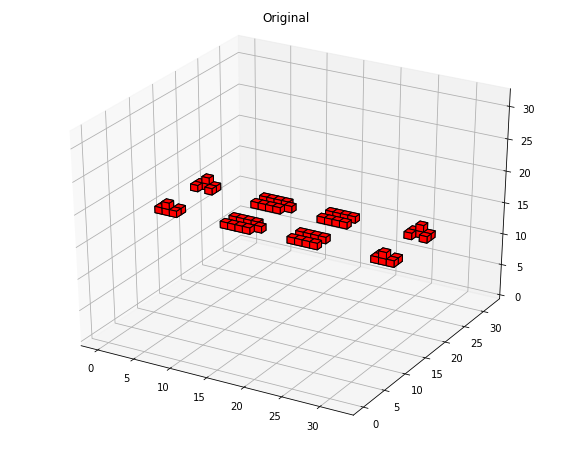

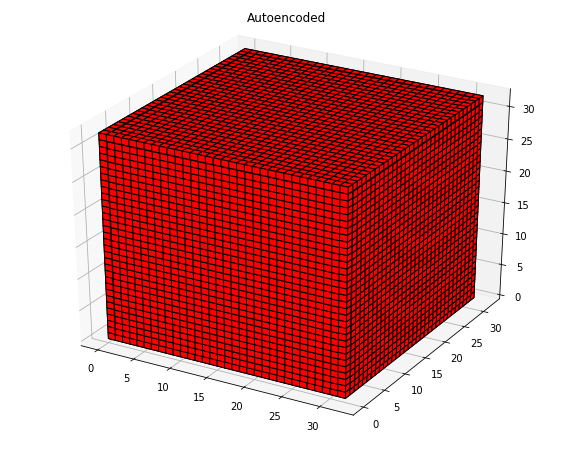

Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/779964.stl already exists at /home/jcworkma/jack/3d-form/src/../data/processed/Thingi10k/voxels/32/779964.binvox
Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/1131717.stl already exists at /home/jcworkma/jack/3d-form/src/../data/processed/Thingi10k/voxels/32/1131717.binvox
Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/931878.stl already exists at /home/jcworkma/jack/3d-form/src/../data/processed/Thingi10k/voxels/32/931878.binvox
Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/37620.stl already exists at /home/jcworkma/jack/3d-form/src/../data/processed/Thingi10k/voxels/32/37620.binvox
Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/41929.stl already exists at /home/jcworkma/jack/3d-form/src/../

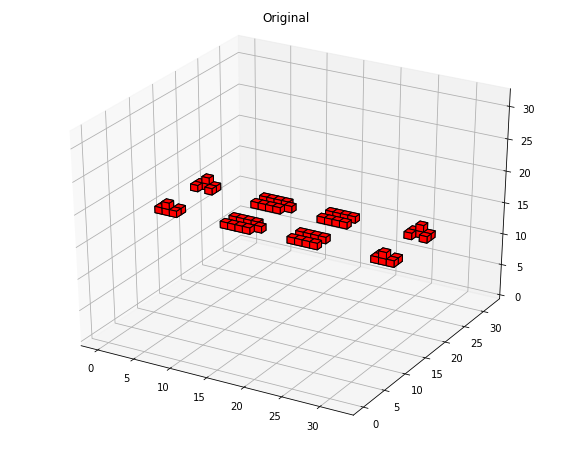

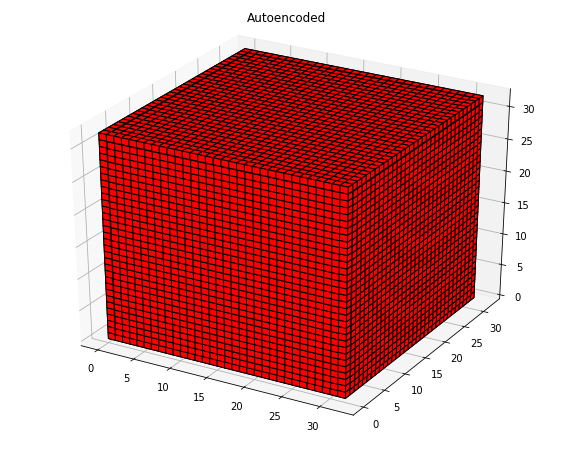

Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/779964.stl already exists at /home/jcworkma/jack/3d-form/src/../data/processed/Thingi10k/voxels/32/779964.binvox
Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/1131717.stl already exists at /home/jcworkma/jack/3d-form/src/../data/processed/Thingi10k/voxels/32/1131717.binvox
Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/931878.stl already exists at /home/jcworkma/jack/3d-form/src/../data/processed/Thingi10k/voxels/32/931878.binvox
Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/37620.stl already exists at /home/jcworkma/jack/3d-form/src/../data/processed/Thingi10k/voxels/32/37620.binvox
Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/41929.stl already exists at /home/jcworkma/jack/3d-form/src/../

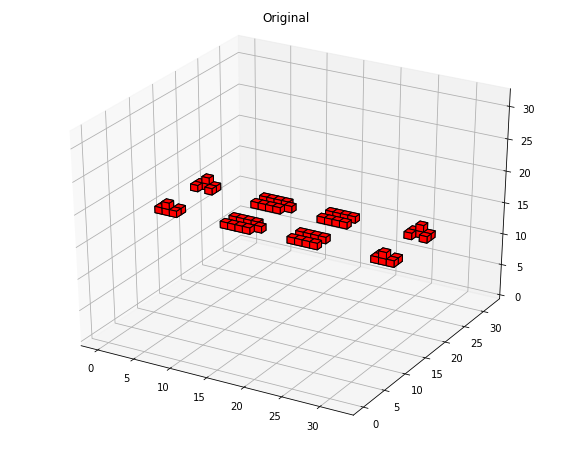

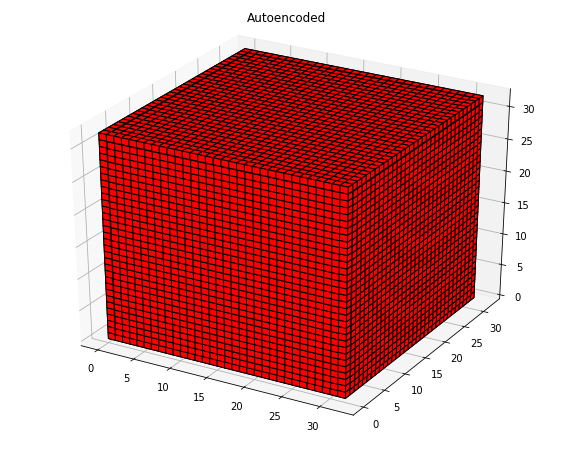

Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/779964.stl already exists at /home/jcworkma/jack/3d-form/src/../data/processed/Thingi10k/voxels/32/779964.binvox
Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/1131717.stl already exists at /home/jcworkma/jack/3d-form/src/../data/processed/Thingi10k/voxels/32/1131717.binvox
Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/931878.stl already exists at /home/jcworkma/jack/3d-form/src/../data/processed/Thingi10k/voxels/32/931878.binvox
Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/37620.stl already exists at /home/jcworkma/jack/3d-form/src/../data/processed/Thingi10k/voxels/32/37620.binvox
Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/41929.stl already exists at /home/jcworkma/jack/3d-form/src/../

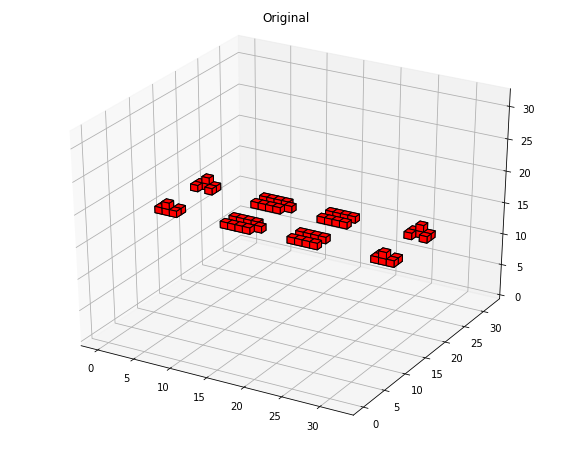

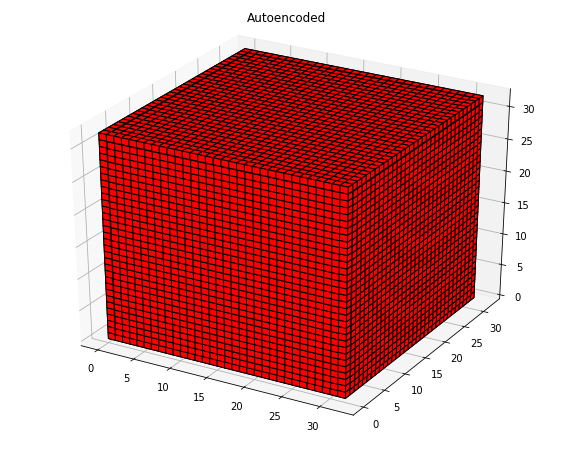

Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/779964.stl already exists at /home/jcworkma/jack/3d-form/src/../data/processed/Thingi10k/voxels/32/779964.binvox
Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/1131717.stl already exists at /home/jcworkma/jack/3d-form/src/../data/processed/Thingi10k/voxels/32/1131717.binvox
Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/931878.stl already exists at /home/jcworkma/jack/3d-form/src/../data/processed/Thingi10k/voxels/32/931878.binvox
Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/37620.stl already exists at /home/jcworkma/jack/3d-form/src/../data/processed/Thingi10k/voxels/32/37620.binvox
Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/41929.stl already exists at /home/jcworkma/jack/3d-form/src/../

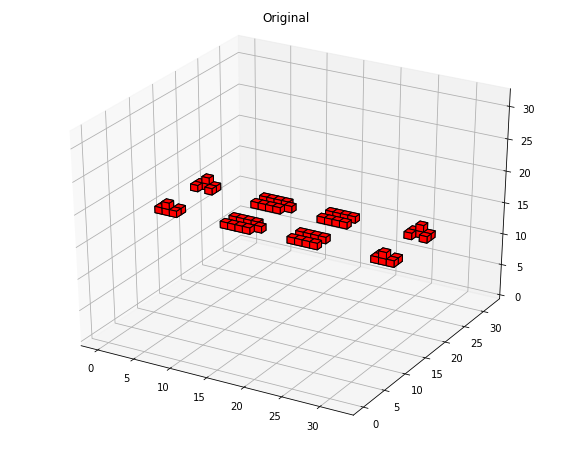

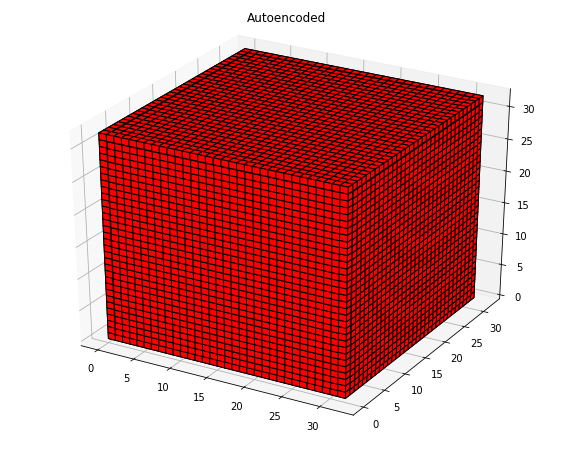

Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/779964.stl already exists at /home/jcworkma/jack/3d-form/src/../data/processed/Thingi10k/voxels/32/779964.binvox
Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/1131717.stl already exists at /home/jcworkma/jack/3d-form/src/../data/processed/Thingi10k/voxels/32/1131717.binvox
Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/931878.stl already exists at /home/jcworkma/jack/3d-form/src/../data/processed/Thingi10k/voxels/32/931878.binvox
Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/37620.stl already exists at /home/jcworkma/jack/3d-form/src/../data/processed/Thingi10k/voxels/32/37620.binvox
Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/41929.stl already exists at /home/jcworkma/jack/3d-form/src/../

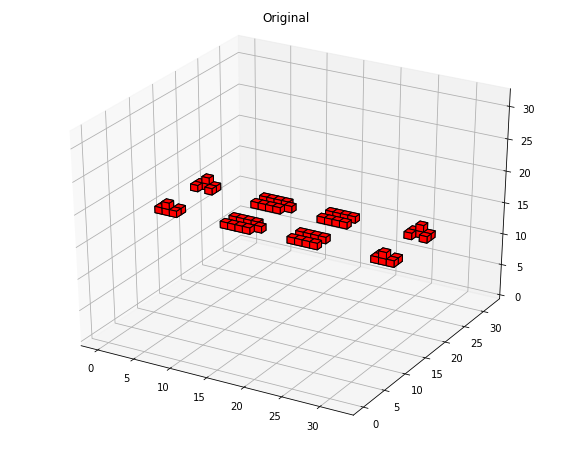

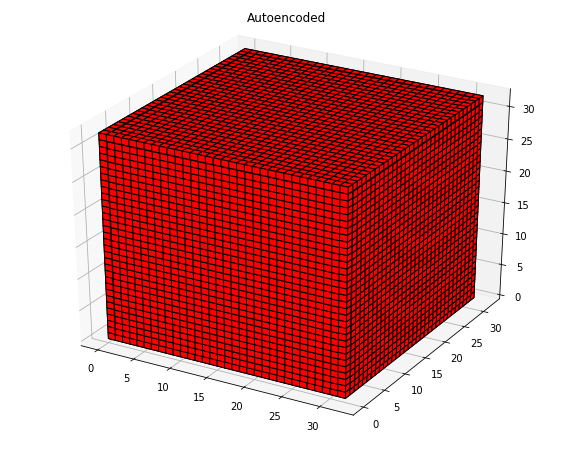

Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/779964.stl already exists at /home/jcworkma/jack/3d-form/src/../data/processed/Thingi10k/voxels/32/779964.binvox
Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/1131717.stl already exists at /home/jcworkma/jack/3d-form/src/../data/processed/Thingi10k/voxels/32/1131717.binvox
Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/931878.stl already exists at /home/jcworkma/jack/3d-form/src/../data/processed/Thingi10k/voxels/32/931878.binvox
Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/37620.stl already exists at /home/jcworkma/jack/3d-form/src/../data/processed/Thingi10k/voxels/32/37620.binvox
Not Voxelizing: Binvox for /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/41929.stl already exists at /home/jcworkma/jack/3d-form/src/../

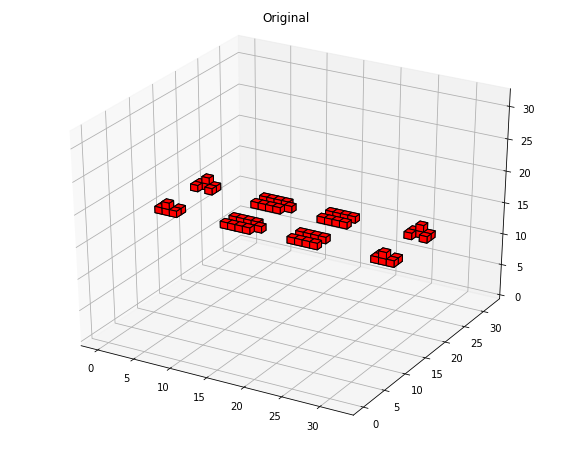

In [ ]:
tf.reset_default_graph()
VOXELS_DIM = 32
BATCH_SIZE = 10

try:
    vae = VariationalAutoencoder(input_dim=VOXELS_DIM,
                                 latent_dim=200,
                                 learning_rate=0.01,
                                 keep_prob=0.8,
                                 verbose=False)

    generator = lambda: thingi.voxels_batchmaker(batch_size=BATCH_SIZE, voxels_dim=VOXELS_DIM, verbose=False)

    vae.train(generator, epochs=5, display_step=1, save_step=10)
except Exception as exc:
    vae.close()
    raise(exc)

In [56]:
from data.voxels import read_voxel_array
path = '/home/jcworkma/jack/3d-form/src/../data/processed/Thingi10k/voxels/32/1131717.binvox'
read_voxel_array(path).dims

[64, 64, 64]

In [23]:
class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, transfer_fct=tf.nn.tanh, 
                 learning_rate=0.001, batch_size=100, ckpt_dir='stl_vae'):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()
        
        # Setup Model Saving
        self.ckpt_dir = os.path.join(MODEL_DIR, ckpt_dir)
        self.saver = tf.train.Saver()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(network_weights["weights_recog"], 
                                      network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        ### original tutorial used tf.mul; I've updated it to tf.multiply for tf 1.0+
        ### https://stackoverflow.com/questions/42217059/tensorflowattributeerror-module-object-has-no-attribute-mul
        self.z = tf.add(self.z_mean, 
                        tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = \
            self._generator_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
                   biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        # Jack: to make not bernoulli, changed to tanh from sigmoid
        x_reconstr_mean = \
            tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), 
                                 biases['out_mean']))
        return x_reconstr_mean
            
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def train(self, generator, training_epochs=10, display_step=1, save_step=1):
        # Training cycle
        start = time.time()
        for epoch_num, epoch in enumerate(range(training_epochs)):
            avg_cost = 0.0

            for batch_num, batch in enumerate(generator()):
                if len(batch) != self.batch_size:
                    continue
                #print('Epoch: {}, Batch: {}'.format(epoch_num, batch_num))

                # Fit training using batch data
                cost = self.partial_fit(batch)

                # Compute average loss
                avg_cost += cost / n_samples * len(batch)

            # Display logs per epoch step
            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), 
                      "cost=", "{:.9f}".format(avg_cost),
                      "Elapsed time: {} mins".format((time.time() - start) / 60))
                print('Generation Example:')
                self.visualize_reconstruction(batch[0])

            if epoch % save_step == 0:
                # Save the variables to disk.
                save_path = self.saver.save(self.sess, os.path.join(self.ckpt_dir, "model_epoch-{}.ckpt".format(epoch)))
                print("Model saved in path: {}".format(save_path))
                                       
        return

    def restore(self, model_ckpt):
        self.saver.restore(self.sess, model_ckpt)
        return
    
    def close(self):
        self.sess.close()
        return
            
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})
    
    def visualize_reconstruction(self, x_sample, sample_name=None):
        # generate a sample from the sample
        x_reconstruct = self.reconstruct(x_sample.reshape([-1, n_input]))

        # reshape into 3x3 vertice
        x_sample_vectors = x_sample.reshape([-1, 3, 3])
        x_reconstruct_vectors = x_reconstruct[0].reshape([-1, 3, 3])
        
        title = '' if not sample_name else ': {}'.format(sample_name)
        plot_mesh(x_sample_vectors, title='Original' + title)
        plot_mesh(x_reconstruct_vectors, title='Autoencoded' + title)
        
        return

In [5]:
# to consider when building the architecture
# tensors can only be so big!
# https://stackoverflow.com/questions/46941747/tensorflow-error-cannot-parse-tensor-from-proto
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=n_input, # length of STL vectors
         n_z=100)  # dimensionality of latent space

BATCH_SIZE = 60
vae = VariationalAutoencoder(network_architecture, 
                             learning_rate=0.1, 
                             batch_size=BATCH_SIZE)

Epoch: 0001 cost= 200367.141768293 Elapsed time: 0.25010273456573484 mins
Generation Example:


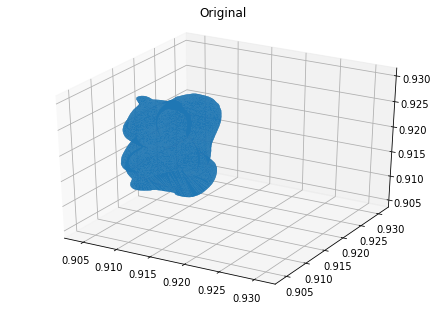

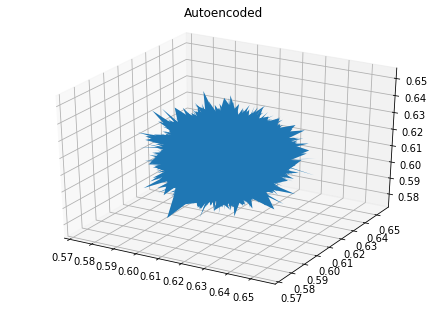

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/stl_vae/model_epoch-0.ckpt
Epoch: 0011 cost= 105172.724847561 Elapsed time: 2.841857997576396 mins
Generation Example:


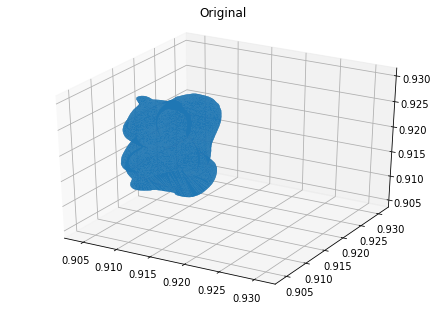

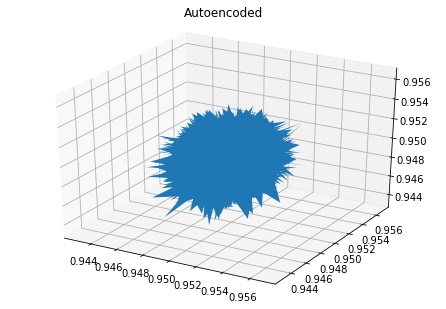

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/stl_vae/model_epoch-10.ckpt
Epoch: 0021 cost= 102588.993902439 Elapsed time: 5.436560690402985 mins
Generation Example:


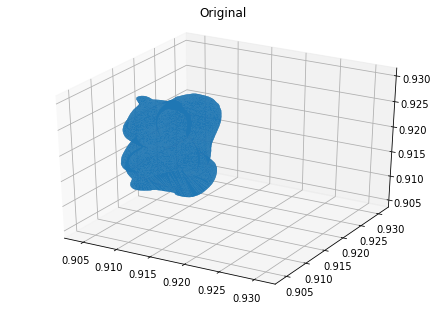

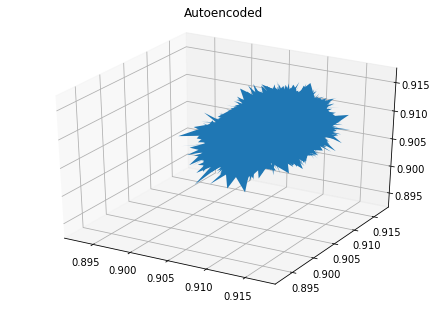

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/stl_vae/model_epoch-20.ckpt
Epoch: 0031 cost= 96539.786585366 Elapsed time: 8.023699748516083 mins
Generation Example:


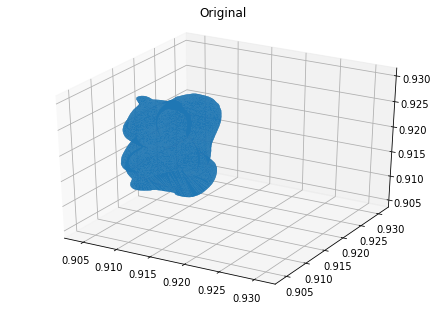

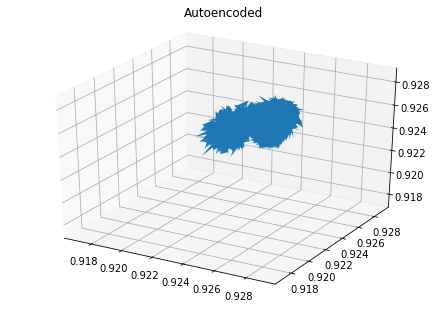

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/stl_vae/model_epoch-30.ckpt
Epoch: 0041 cost= 92943.090701220 Elapsed time: 10.608817692597707 mins
Generation Example:


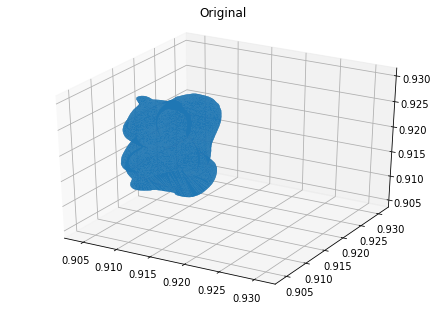

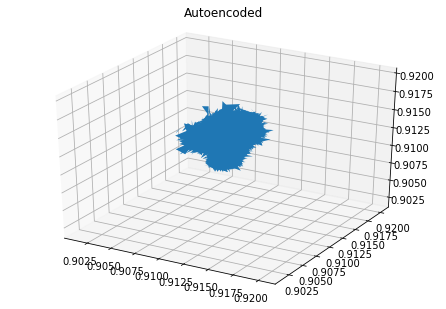

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/stl_vae/model_epoch-40.ckpt
Epoch: 0051 cost= 90254.679878049 Elapsed time: 13.200877634684245 mins
Generation Example:


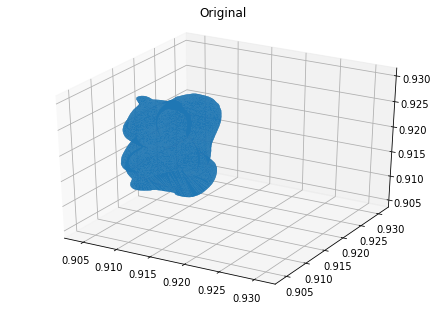

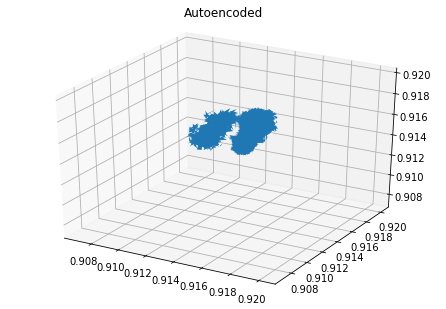

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/stl_vae/model_epoch-50.ckpt
Epoch: 0061 cost= 88242.507621951 Elapsed time: 15.930791187286378 mins
Generation Example:


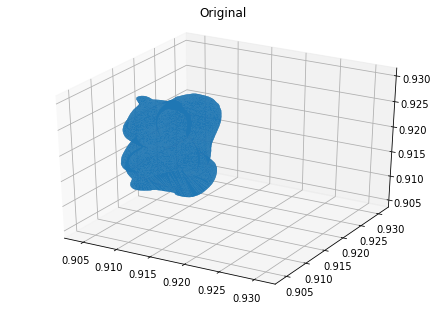

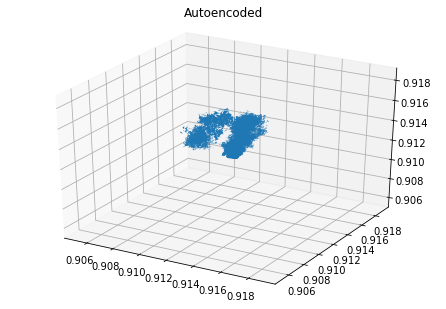

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/stl_vae/model_epoch-60.ckpt
Epoch: 0071 cost= 86736.451981707 Elapsed time: 18.687038040161134 mins
Generation Example:


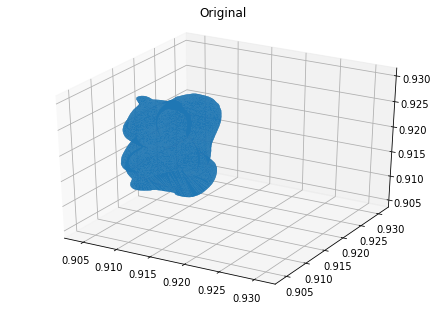

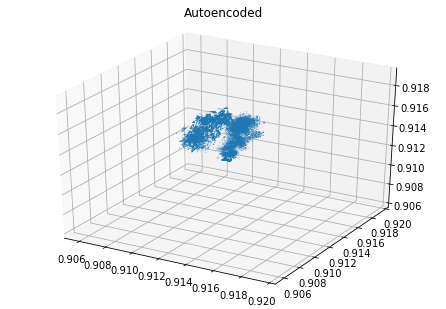

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/stl_vae/model_epoch-70.ckpt
Epoch: 0081 cost= 85615.384908537 Elapsed time: 21.407950512568156 mins
Generation Example:


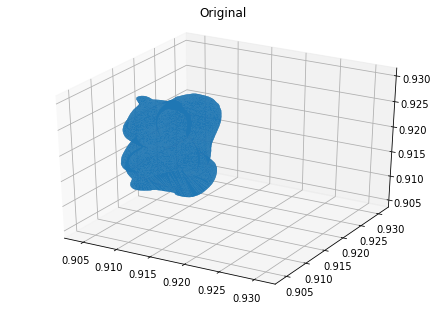

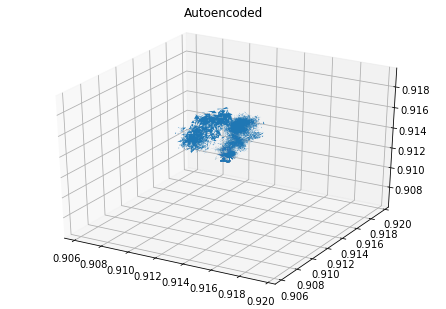

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/stl_vae/model_epoch-80.ckpt
Epoch: 0091 cost= 84781.505335366 Elapsed time: 24.142562278111775 mins
Generation Example:


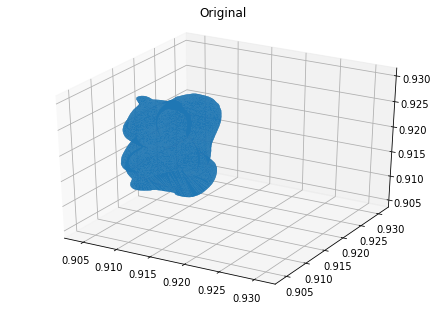

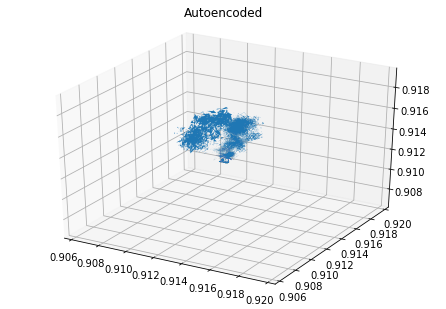

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/stl_vae/model_epoch-90.ckpt


In [6]:
generator = lambda: thingi.batchmaker(BATCH_SIZE, normalize=True, flat=True, pad_length=n_input, filenames=False)

vae.train(generator, training_epochs=100, display_step=10, save_step=10)

# 10 epochs produces the same stl dump regardless of input; perhaps a sign of overtraining
# "best" reconstructed image was from a model trained on 80 epochs on Thingi10:
# https://github.com/workmanjack/3d-form/blob/047081c799eb866cdfcc81ee653ac30d7698cffe/notebooks/stl_vae.ipynb
#
# it is looking like same results (that two cluster split) is a result of undertraining; 16 epochs on full dataset
# yielded the two cluster split (and so did all previous), then 21 epochs on full dataset yielded a single,
# more concise blob!
# 

In [7]:
# get an example from thingi10k
# todo... really should be able to pull an example without batch generator...
for batch in thingi.batchmaker(10, normalize=True, flat=True, pad_length=n_input, filenames=True):
    stl_file, x_sample = batch[5]
    break

# generate a sample from the sample
x_reconstruct = vae.reconstruct(x_sample.reshape([-1, n_input]))

# reshape into 3x3 vertices
print('Source: {}'.format(stl_file))
x_sample_vectors = x_sample.reshape([-1, 3, 3])
x_reconstruct_vectors = x_reconstruct[0].reshape([-1, 3, 3])

Source: /home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/299291.stl


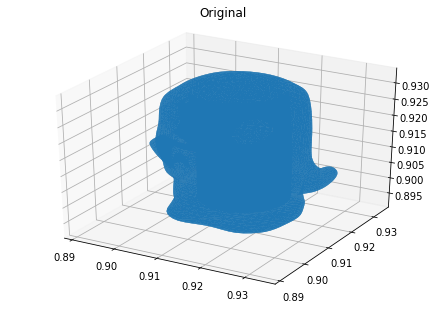

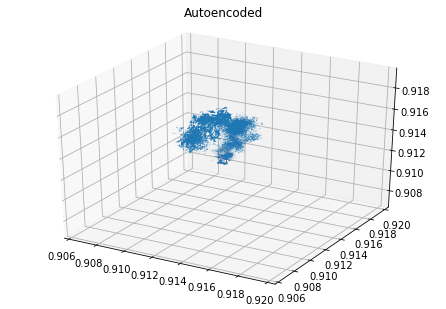

In [8]:
from data.stl import plot_mesh


plot_mesh(x_sample_vectors, title='Original')
plot_mesh(x_reconstruct_vectors, title='Autoencoded')

In [9]:
save_vectors_as_stl(vectors, 'first_vae_stl.stl')

NameError: name 'vectors' is not defined

## Restoring and Reusing a Model

In [ ]:
vae.restore(os.path.join(MODEL_DIR, 'stl_vae', 'model_epoch-70.ckpt'))

In [ ]:
# get an example from thingi10k
# todo... really should be able to pull an example without batch generator...
for batch in thingi.batchmaker(10, normalize=True, flat=True, pad_length=n_input, filenames=True):
    stl_file, x_sample = batch[5]
    break

# generate a sample from the sample
x_reconstruct = vae.reconstruct(x_sample.reshape([-1, n_input]))

# reshape into 3x3 vertices
print('Source: {}'.format(stl_file))
x_sample_vectors = x_sample.reshape([-1, 3, 3])
x_reconstruct_vectors = x_reconstruct[0].reshape([-1, 3, 3])

In [ ]:
from data.stl import plot_mesh


plot_mesh(x_sample_vectors, title='Original')
plot_mesh(x_reconstruct_vectors, title='Autoencoded')